In [30]:
import tensorflow as tf
import wandb
import dlomix
import dlomix.losses
from dlomix.data import load_processed_dataset
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import yaml
from dlomix.losses import masked_spectral_distance
import tqdm

In [23]:
model_dir = "/cmnfs/proj/bmpc_dlomix/models/baseline_models"
noptm_model_path = f"{model_dir}/noptm_baseline_small_bs1024_unmod_extended/873ee240-8a06-4fd3-ac6f-50b714788eb6.keras"
ptm_model_path = f"{model_dir}/ptm_baseline_small_cleaned_bs1024/12727ebb-38d4-446d-89b6-c1261588dd64.keras"

In [24]:
noptm_model = tf.keras.models.load_model(noptm_model_path)
print(noptm_model.summary())

Model: "prosit_intensity_predictor_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  464       
                                                                 
 sequential_10 (Sequential)  (None, 30, 512)           1996800   
                                                                 
 sequential_11 (Sequential)  multiple                  4608      
                                                                 
 sequential_12 (Sequential)  (None, 29, 512)           1576806   
                                                                 
 encoder_att (AttentionLaye  multiple                  542       
 r)                                                              
                                                                 
 sequential_13 (Sequential)  multiple                  0         
                                      

In [25]:
ptm_model = tf.keras.models.load_model(ptm_model_path)
print(ptm_model.summary())

Model: "prosit_intensity_predictor_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     multiple                  928       
                                                                 
 sequential_15 (Sequential)  (None, 30, 512)           1996800   
                                                                 
 sequential_16 (Sequential)  multiple                  4608      
                                                                 
 sequential_17 (Sequential)  (None, 29, 512)           1576806   
                                                                 
 encoder_att (AttentionLaye  multiple                  542       
 r)                                                              
                                                                 
 sequential_18 (Sequential)  multiple                  0         
                                      

In [26]:
def load_config(config_path):
    with open(config_path, 'r') as yaml_file:
        config = yaml.safe_load(yaml_file)
        return config

def load_dataset_from_config(config):
    path = config['dataset']['processed_path']
    return load_processed_dataset(path)

In [27]:
noptm_data_config = load_config('../bmpc_shared_scripts/prepare_dataset/config_files/noptm_baseline_small_bs1024_unmod_extended.yaml')
noptm_data = load_dataset_from_config(noptm_data_config)
ptm_data_config = load_config('../bmpc_shared_scripts/prepare_dataset/config_files/ptm_baseline_small_cleaned_bs1024.yaml')
ptm_data = load_dataset_from_config(ptm_data_config)

In [58]:
def evaluate_model(model, dataset):
    spectral_distances = []
    for batch, y_true in tqdm.tqdm(dataset.tensor_val_data):
        y_pred = model.predict(batch)
        spectral_distances.extend(masked_spectral_distance(y_true=y_true, y_pred=y_pred).numpy())
    return spectral_distances

def plot_spectral_angles(spectral_distances):
    spectral_angles = [1 - sd for sd in spectral_distances]
    avg = np.mean(spectral_angles)
    fig,ax = plt.subplots()
    p = sns.histplot(spectral_angles, ax=ax)
    p.text(0.1, 0.9, f'Avg. SA = {avg:.2}', transform=ax.transAxes)
    plt.title('SA distribution of test set with no PTMs')
    plt.xlabel('Spectral Angle')
    plt.tight_layout()

  0%|          | 0/4 [00:00<?, ?it/s]

32/32 [==============================] - 3s 91ms/step


 25%|██▌       | 1/4 [00:03<00:09,  3.19s/it]

32/32 [==============================] - 3s 93ms/step


 50%|█████     | 2/4 [00:06<00:06,  3.21s/it]

32/32 [==============================] - 3s 91ms/step


 75%|███████▌  | 3/4 [00:09<00:03,  3.15s/it]

29/29 [==============================] - 3s 91ms/step


100%|██████████| 4/4 [00:12<00:00,  3.09s/it]


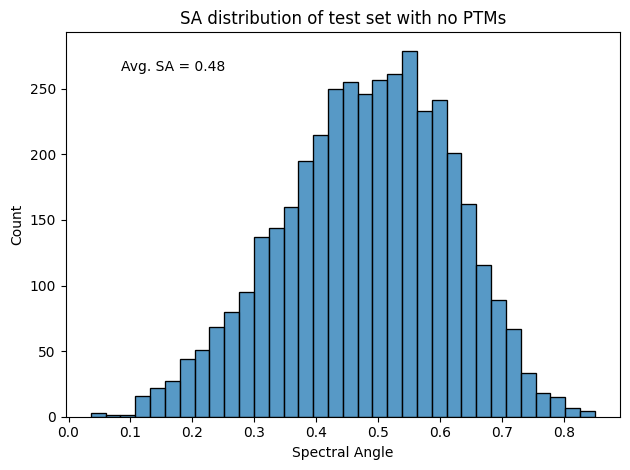

In [64]:
val_noptm_model_noptm_data = evaluate_model(noptm_model, noptm_data)
plot_spectral_angles(val_noptm_model_noptm_data)

  0%|          | 0/4 [00:00<?, ?it/s]

32/32 [==============================] - 3s 90ms/step


 25%|██▌       | 1/4 [00:03<00:09,  3.18s/it]

32/32 [==============================] - 3s 91ms/step


 50%|█████     | 2/4 [00:06<00:06,  3.13s/it]

32/32 [==============================] - 3s 90ms/step


 75%|███████▌  | 3/4 [00:09<00:03,  3.09s/it]

29/29 [==============================] - 3s 91ms/step


100%|██████████| 4/4 [00:12<00:00,  3.05s/it]


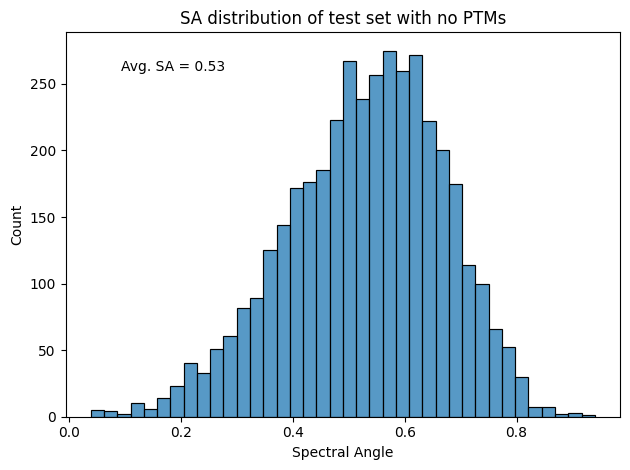

In [63]:
val_ptm_model_ptm_data = evaluate_model(ptm_model, ptm_data)
plot_spectral_angles(val_ptm_model_ptm_data)

  0%|          | 0/4 [00:00<?, ?it/s]

32/32 [==============================] - 3s 90ms/step


 25%|██▌       | 1/4 [00:03<00:09,  3.16s/it]

32/32 [==============================] - 3s 91ms/step


 50%|█████     | 2/4 [00:06<00:06,  3.11s/it]

32/32 [==============================] - 3s 91ms/step


 75%|███████▌  | 3/4 [00:09<00:03,  3.08s/it]

29/29 [==============================] - 3s 91ms/step


100%|██████████| 4/4 [00:12<00:00,  3.04s/it]


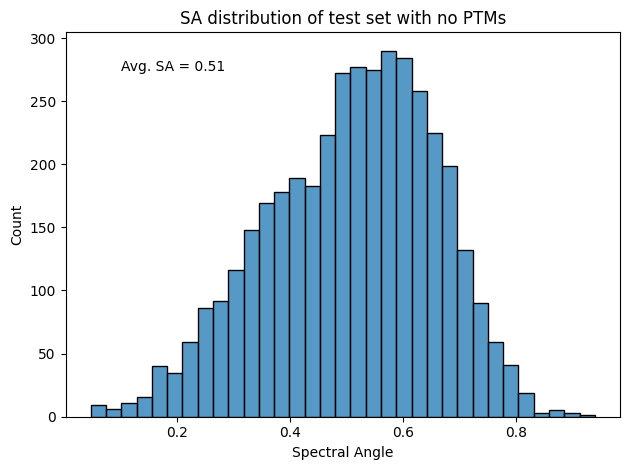

In [62]:
val_ptm_model_noptm_data = evaluate_model(ptm_model, noptm_data)
plot_spectral_angles(val_ptm_model_noptm_data)